In [1]:
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Geodesy
using ForwardDiff
using Optim
using Plots

In [2]:
#GS Locations
wean_lla = LLA(40.4427217, -79.9479335, 17.0)
wean_ecef = ECEF(wean_lla, wgs84)
gs_ecef = Array(wean_ecef)./(1000.0)

3-element Array{Float64,1}:
   848.4495513714031
 -4786.358163650972
  4115.532370991342

In [64]:
function ecef2eci(x_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
end

function ecef2eci(x_ecef,v_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
    v_eci = [c -s 0; s c 0; 0 0 1]*(v_ecef + cross([0;0;Ω],x_ecef))
end

function eci2ecef(x_eci,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_ecef = [c -s 0; s c 0; 0 0 1]'*x_eci
end

function hat(x)
    S = [0 -x[3] x[2];
         x[3] 0 -x[1];
        -x[2] x[1] 0]
end

hat (generic function with 1 method)

In [4]:
gs_eci = ecef2eci(gs_ecef, 100.0)
gs_ecef - eci2ecef(gs_eci, 100.0)

3-element Array{Float64,1}:
  0.0
 -9.094947017729282e-13
  0.0

In [5]:
function dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [v; a]
end

function backward_dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [-v; -a]
end

function f_c(x)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    return [v; a]
end

function f_d(x)
    h = 0.1 #RK4 step (seconds)
    
    k1 = f_c(x)
    k2 = f_c(x + 0.5*h*k1)
    k3 = f_c(x + 0.5*h*k2)
    k4 = f_c(x + h*k3)
    
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
end

function A(x)
    return ForwardDiff.jacobian(f_d, x)
end

A (generic function with 1 method)

In [87]:
#Initial Conditions (near-polar orbit passing directly over GS at t=0)
μ = 398600.44 #km^3/s^2
Re = 6371.0 #km
r0 = (Re+550)*(gs_ecef/norm(gs_ecef))
v0 = cross(r0, cross(r0,[0;0;1]))
v0 = sqrt(μ/norm(r0))*v0/norm(v0)
Q = exp(hat((7.0*pi/180.0).*r0/norm(r0)))
v0 = Q*v0
x0 = [r0; v0]

6-element Array{Float64,1}:
   921.9556818709577
 -5201.028272470356
  4472.084930949979
     1.7601994541041912
    -4.631026120758353
    -5.748755685435792

In [88]:
#Integrate backward for 5 minutes
tspan = (0.0,5.0*60.0)
prob1 = ODEProblem(backward_dynamics!,[r0; v0],tspan)
soln1 = solve(prob1, Tsit5(), reltol=1e-9, abstol=1e-9)

#Integrate forward for 5 minutes
tspan = (0.0,5.0*60.0)
prob2 = ODEProblem(dynamics!,[r0; v0],tspan)
soln2 = solve(prob2, Tsit5(), reltol=1e-9, abstol=1e-9)

#Sample satellite state every N seconds
thist = Array(range(-5.0*60.0, 5.0*60.0, step=10.0))
xhist = zeros(6,length(thist))
for k = 1:length(thist)
    if thist[k] < 0.0
        xhist[:,k] .= soln1(-thist[k])
    else
        xhist[:,k] .= soln2(thist[k])
    end
end

In [89]:
function g(x,t)
    x_sat = xhist[1:3,t]
    v_sat = xhist[4:6,t]
    x_gs = ecef2eci(x,t)
    v_gs = ecef2eci(x,[0.0; 0.0; 0.0],t)
    
    
    r = x_sat-x_gs
    
    v_r = ((v_sat-v_gs)'*r)/norm(r)
    dopp = -(v_r/3e5)*400e6
end

function C(x,t)
    gdiff(z) = g(z,t)
    C1 = ForwardDiff.gradient(gdiff, x)
    return C1'
end

C (generic function with 1 method)

In [90]:
#Calculate elevation
ele = zeros(length(thist))
for k = 1:length(thist)
    gs_eci = ecef2eci(gs_ecef,thist[k])
    y = (xhist[1:3,k]-gs_eci)
    ele[k] = (y/norm(y))'*(gs_eci/norm(gs_eci))
end

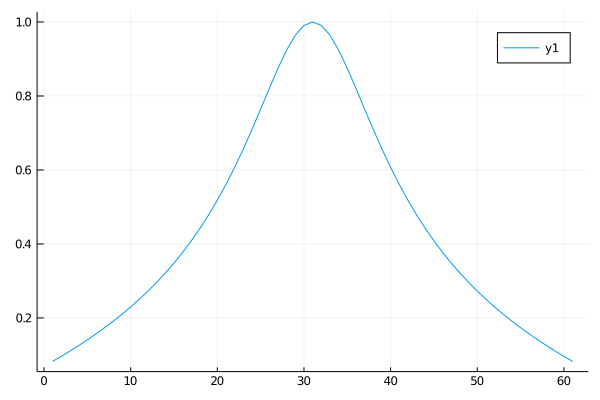

In [91]:
plot(ele)

In [102]:
function crbound(σf)
    #Cramer-Rao Bound
    R = σf^2
    Rinv = 1.0/R
    
    C1 = C(gs_ecef,1)
    S = C1'*Rinv*C1 #inverse state covariance (information)
    for k = 2:length(thist)
        Ck = C(gs_ecef,k)
        S = S + Ck'*Rinv*Ck
    end
    sqrt(sum(Diagonal(S^-1)))
end

crbound (generic function with 1 method)

In [106]:
crbound(0.5)

0.28498093339479097